# Utilizing continuous drug representations

In this notebook, the model is tested in its ability to predict on held out drugs or drug pairs by using a continuous representation of the drugs.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

drugs = pd.read_csv("../synpred/data/ONeil_drug_representation.csv")
data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")

In [110]:
X = drugs.iloc[:,2:]
X = X.apply(zscore)
drugs = drugs.iloc[:,0:1]
XA = X.add_prefix("A")
XB = X.add_prefix("B") 

drugsA = pd.concat([drugs,XA],axis=1)
drugsB = pd.concat([drugs,XB],axis=1)

data = pd.merge(data,drugsA,left_on="DrugA",right_on="Name")
data = pd.merge(data,drugsB,left_on="DrugB",right_on="Name")
data = data.drop(columns=["Name_x","Name_y"])
data.dropna(inplace = True)

In [111]:
# Sort the data, and pull out a single cell line
data = data.sort_values(["CellLine","DrugA","DrugB"])
k = 1*289*100 # We have 289 unique drug combinations, with 100 concentrations each. This pulls out first cell line
data = data.head(k)
print(data["CellLine"].unique()) # Should be a single value here

['A2058']


In [112]:
# Normalize data per experiment
#data['GPMean'] = data.groupby(["CellLine","DrugA","DrugB"])['GPMean'].transform(lambda x: (x - x.mean()) / x.std())

# Normalize total data
#data['GPMean'] = data['GPMean'].transform(lambda x: (x - x.mean()) / x.std())

In [113]:
# Now splitting the dataset into a test and train set
from sklearn.model_selection import train_test_split
k = np.floor(289*0.8)
data["combination"] = data.DrugA.map(str) + "_" + data.DrugB
train_combinations, test_combinations = train_test_split(pd.DataFrame(data.combination.unique()), test_size=0.2)
train = data[data["combination"].isin(train_combinations[0].tolist())]
test = data[data["combination"].isin(test_combinations[0].tolist())]
# Now drop the combination column
train = train.drop(columns=["combination"])
test = test.drop(columns=["combination"])

In [114]:
# Now setting up the actual datasets
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
y_train = torch.tensor(train["GPMean"].values).float()
y_test = torch.tensor(test["GPMean"].values).float()
conc_train = train[['DrugAconc','DrugBconc']]
conc_test = test[['DrugAconc','DrugBconc']]
drugcovars_train = train.iloc[:,-(50*2):]
drugcovars_test = test.iloc[:,-(50*2):]
X_train = torch.tensor(pd.concat([conc_train,drugcovars_train],axis=1).values).float()
X_test = torch.tensor(pd.concat([conc_test,drugcovars_test],axis=1).values).float()

# Noise vectors
y_noise = torch.tensor(train["GPVar"].values).float()

In [115]:
# Setting up minibatching
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
train_dataset = TensorDataset(X_train, y_train, y_noise)
sampler = WeightedRandomSampler(y_train.abs(),len(y_train),replacement=True)
train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [154]:
# Setting up the models
from synpred.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy


### Model 4 -- RBF + ARD
class DrugCombModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),
                                 torch.linspace((2+50),1+(2*50),50),torch.linspace(2,1+50,50)]).long()
        # Inducing points init from training data
        #ind_indices = torch.randperm(X_train.size(0))
        #inducing_points = torch.stack([X_train[ind_indices[:500]]],
        #                               dim=0)
        # Inducing points where the action is!
        p = y_train.abs().div(y_train.abs().sum())
        idx = p.multinomial(num_samples=500, replacement=False)
        inducing_points = torch.stack([X_train[idx]],
                                       dim=0).squeeze(0)
        
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2))
        
        
        # Variational Strategy
        variational_strategy = PermutationInvariantVariationalStrategy(
            self, inducing_points, variational_distribution, 
            permutation=permutation,
            learn_inducing_locations=True)

        
        super(DrugCombModel,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean()
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.ScaleKernel(
                                            gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]))
                                            ) 
        # Covar over the drugs, RBF + ARD
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,2*50+1,2*50).long(),
                                                            ard_num_dims=2*50)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


    
model = DrugCombModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=y_noise, learn_additional_noise=True)

In [155]:
# Check that initialization is decent
init_loss = []
#models = []
#likelihoods = []
#ind = torch.randperm(X_train.size(0))
p = y_train.abs().div(y_train.abs().sum())
idx = p.multinomial(num_samples=1000, replacement=False)
X_mll = X_train[idx]
y_mll = y_train[idx]
y_noise_mll = y_noise[idx]
model = DrugCombModel()
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=y_noise_mll, learn_additional_noise=True)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))
output = model(X_mll)
loss = -mll(output, y_mll)
for i in range(100):
    # Now continue in 
    newmodel = DrugCombModel()
    #newlikelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=y_noise_mll,learn_additional_noise=True)
    newlikelihood = gpytorch.likelihoods.GaussianLikelihood()
    newmodel.train()
    newlikelihood.train()
    newmll = gpytorch.mlls.VariationalELBO(newlikelihood, newmodel, num_data=y_mll.size(0))
    newoutput = newmodel(X_mll)
    newloss = -newmll(newoutput, y_mll)
    # If this loss is better overwrite
    if newloss.item() < loss.item():
        print("Old loss: ", loss.item())
        print("New loss: ", newloss.item())
        model = newmodel
        likelihood = newlikelihood
        loss = newloss
        
    else:
        # Delete everthing
        import gc
        del newmodel
        del newlikelihood
        del newloss
        del newmll
        del newoutput
        gc.collect()


Old loss:  2.5203304290771484
New loss:  2.520296573638916
Old loss:  2.520296573638916
New loss:  2.5202951431274414
Old loss:  2.5202951431274414
New loss:  2.5202560424804688
Old loss:  2.5202560424804688
New loss:  2.5202229022979736


In [156]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
from torch.optim.lr_scheduler import MultiStepLR
num_epochs = 40 # Number of complete passes through the data

# Will train all models in the same loop

model.train()
likelihood.train()
hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
variational_ngd_optimizer = gpytorch.optim.NGD(
    model.variational_parameters(), 
    num_data=y_train.size(0), lr=0.01)

scheduler_hypers = MultiStepLR(hyperparameter_optimizer, milestones=[#0.25 * num_epochs,
                                                                     0.50 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)
scheduler_variational = MultiStepLR(variational_ngd_optimizer, milestones=[#0.25 * num_epochs,
                                                                     0.50 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)
# Tracking loss
train_loss = []


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
with gpytorch.settings.cholesky_max_tries(12):
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch, y_noise_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer.zero_grad()
            variational_ngd_optimizer.zero_grad()
            # Get outputs
            output = model(x_batch)
            # Compute loss
            #loss = -mll(output, y_batch, noise=y_noise_batch)
            loss = -mll(output, y_batch)
            # Call backward on loss
            loss.backward()
            # Take a step
            hyperparameter_optimizer.step()
            variational_ngd_optimizer.step()
            
            
            # Update counter
            minibatch_iter.set_postfix(loss=loss.item())
            
            # Track loss
            train_loss.append(loss.item())
            
            
        # Step learning rate scheduler
        scheduler_hypers.step()
        scheduler_variational.step()
        

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/91 [00:00<?, ?it/s]

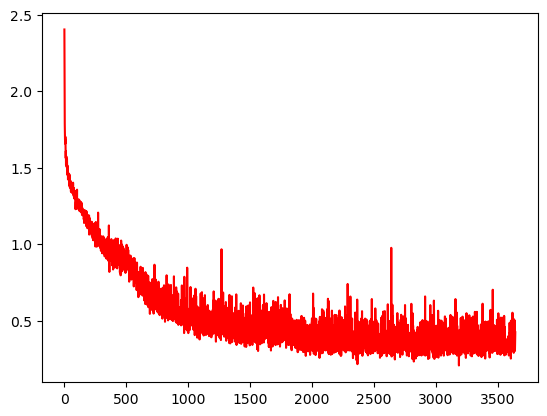

In [157]:
plt.plot(torch.tensor(train_loss), "r-")

In [158]:
# Set into eval mode
model.eval()

likelihood.eval()

# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_max_tries(12):
    predictions = likelihood(model(X_test))
    
    mean = predictions.mean
    
    #lower, upper = predictions.confidence_region()



In [159]:
mean

tensor([-0.0972, -0.1509, -0.2044,  ..., -0.0376,  0.3272,  0.5327])

In [160]:
mean_trunc = torch.mean(mean,dim=0)

In [161]:
mean_trunc

tensor(-0.1602)

In [162]:
mean_trunc[mean_trunc < 0] = 0
mean_trunc[mean_trunc > 1] = 1


In [163]:
mean_trunc.max()

tensor(0.)

In [164]:
print(np.corrcoef(mean,y_test))
print(np.corrcoef(test["p0Mean"].values,y_test))

[[1.         0.56471797]
 [0.56471797 1.        ]]
[[1.         0.13064883]
 [0.13064883 1.        ]]


In [165]:
y_test

tensor([-0.0377, -0.0400, -0.0466,  ...,  1.1003,  1.8069,  1.5118])

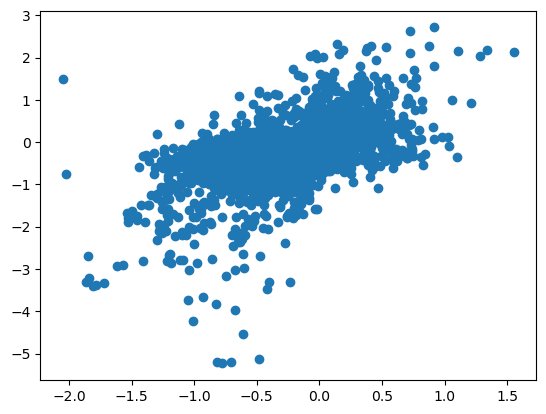

In [166]:
plt.scatter(mean.numpy(),y_test)

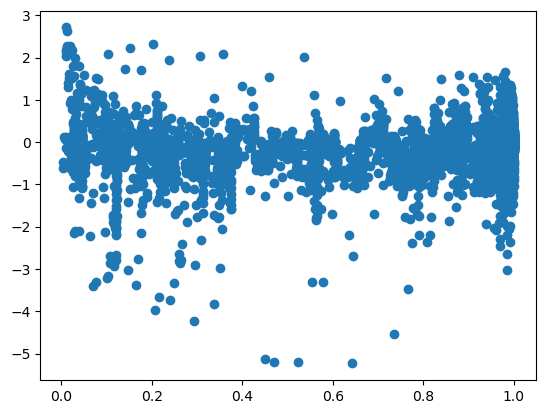

In [167]:
plt.scatter(test["p0Mean"].values,y_test)

In [168]:
b1 = test["b1"]
b2 = test["b2"]
p0 = test["p0Mean"]
Delta_hat = -p0/(1+np.exp(b1*mean.numpy()+np.log(p0/(1-p0)))) + (1-p0)/(1+np.exp(-b2*mean.numpy()-np.log(p0/(1-p0))))
f_hat = p0 + Delta_hat

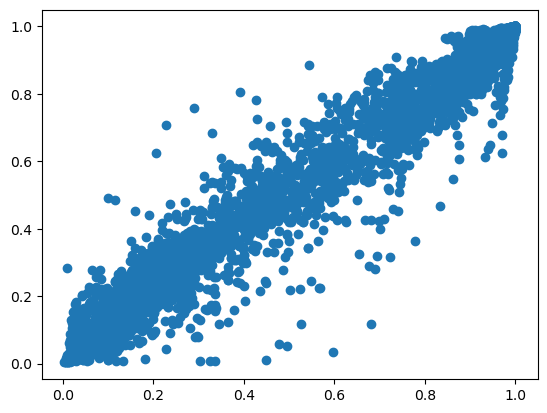

In [169]:
plt.scatter(f_hat,test["fMean"])

In [170]:
print(np.corrcoef(f_hat,test["fMean"]))

[[1.         0.98408627]
 [0.98408627 1.        ]]


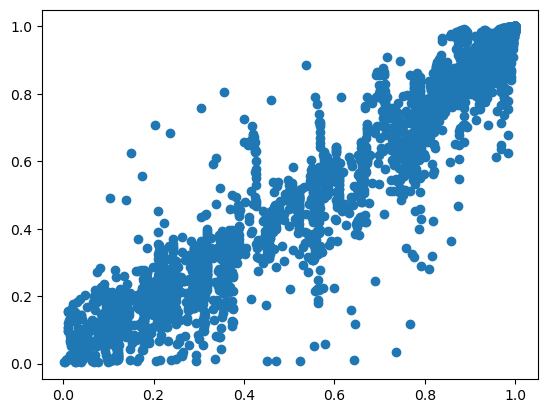

In [171]:
plt.scatter(test["p0Mean"],test["fMean"])

In [153]:
print(np.corrcoef(test["p0Mean"],test["fMean"]))

[[1.         0.97742444]
 [0.97742444 1.        ]]
